# Movies' related-ness

### key words: Recommendation System, nlp, tdidf, MovieLens

Here, the goal is to build a model / code that orders movies based on their "relatedness" using the MovieLens
20M dataset (https://grouplens.org/datasets/movielens/20m/) which contains over 20 thousands movie titles. We will frame the problem
regarding the “relatedness” of movies and after exploring the dataset, we will show different
approaches to propose an ordered list of movies given a particular one.

Coming from the field of supervised learning, the recommendation system / discovery search is quite new and quite substile, I had to make some research in order to understand the complexity of the recommendation engine field and to understand how the subjectivity of the movies relatedness can be measured.

To say that two movies are related can be interpreted in many ways: the similarity in the titles, the
description, the genres, the year range, the popularity or the ratings relative to one-another is one way
to define the relatedness between movies.

In this exercise, we will try to explore quickly the dataset, propose some features for relatedness and
explore different techniques that I discovered over the last few days during my readings.

The code was developed in python on an AWS EC2 instance.

In [3]:
# Readings:

# https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016
# https://www.kaggle.com/rounakbanik/movie-recommender-systems
# https://stackoverflow.com/questions/42440621/how-term-frequency-is-calculated-in-tfidfvectorizer/42451555#42451555
# https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
# https://en.wikipedia.org/wiki/Learning_to_rank
# https://stackoverflow.com/questions/44741928/beautifulsoup-scraping-titles-from-www-themoviedb-org
# https://www.coursera.org/specializations/recommender-systems?ranMID=40328&ranEAID=je6NUbpObpQ&ranSiteID=je6NUbpObpQ-SDyYTYayqBBJtH85YOKI1A&siteID=je6NUbpObpQ-SDyYTYayqBBJtH85YOKI1A&utm_content=10&utm_medium=partners&utm_source=linkshare&utm_campaign=je6NUbpObpQ

# https://beckernick.github.io/matrix-factorization-recommender/
# https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

In [4]:
import pandas as pd
import gc
import glob
import numpy as np

In [5]:
%matplotlib inline
import matplotlib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [6]:
!ls

main.ipynb  ml-20m.zip	ml20m  scraping.ipynb


Dataset is available here: https://grouplens.org/datasets/movielens/20m/

In [7]:
data_fld = '/jet/prs/workspace/Movie/ml20m/'
glob.glob(data_fld+ '*')

['/jet/prs/workspace/Movie/ml20m/genome-scores.csv',
 '/jet/prs/workspace/Movie/ml20m/movies.csv',
 '/jet/prs/workspace/Movie/ml20m/genome-tags.csv',
 '/jet/prs/workspace/Movie/ml20m/tags.csv',
 '/jet/prs/workspace/Movie/ml20m/ratings.csv',
 '/jet/prs/workspace/Movie/ml20m/README.txt',
 '/jet/prs/workspace/Movie/ml20m/movie_desc.csv',
 '/jet/prs/workspace/Movie/ml20m/links.csv']

In [8]:
for file_path in [f for f in glob.glob(data_fld+ '*') if f.split('.')[-1]=='csv']:
    file_read = pd.read_csv(file_path)
    print(file_path, " ", file_read.shape)
    print(file_read.head())
    

/jet/prs/workspace/Movie/ml20m/genome-scores.csv   (11709768, 3)
   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675
/jet/prs/workspace/Movie/ml20m/movies.csv   (27278, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
/jet/prs/workspace/Movie/ml20m/genome-tags.csv   (1128, 2)
   tagId           tag
0      1           007
1     

In [9]:
file_read = pd.read_csv('/jet/prs/workspace/Movie/ml20m/genome-scores.csv')
print('unique movie Ids: ', len(file_read.movieId.unique()))

unique movie Ids:  10381


In [10]:
movies_orig = pd.read_csv('/jet/prs/workspace/Movie/ml20m/movies.csv')
print('unique movie Ids: ', len(movies_orig.movieId.unique())), movies_orig.columns

unique movie Ids:  27278


(None, Index(['movieId', 'title', 'genres'], dtype='object'))

In [11]:
print('number of Ids:', len(movies_orig.movieId.unique()), " | ","number of titles:" ,len(movies_orig.title.unique()))

number of Ids: 27278  |  number of titles: 27262


In [12]:
print('duplicated movies:')
pd.concat(g for _, g in movies_orig.groupby("title") if len(g) > 1)

duplicated movies:


,movieId,title,genres
20923,102190,"20,000 Leagues Under the Sea (1997)",Adventure|Romance|Sci-Fi
24064,114130,"20,000 Leagues Under the Sea (1997)",Romance|Sci-Fi
582,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
24092,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy
21429,104035,Beneath (2013),Horror
24437,115777,Beneath (2013),Horror
13417,66140,Blackout (2007),Horror|Thriller
16827,85070,Blackout (2007),Drama
10694,42015,Casanova (2005),Action|Adventure|Comedy|Drama|Romance
26808,128862,Casanova (2005),Comedy|Drama|Romance


It look like some entries have been updated by adding a new records: the last record seems to be the correct one

In [13]:
# remove the duplicates and keep last record
movies_orig = movies_orig.drop_duplicates(subset=['title'], keep='last')
movies_orig.shape

(27262, 3)

In [14]:
# cleaning the genres for the purpose of later vectorization
movies_orig.genres = movies_orig.genres.apply(lambda x: str(x).replace("-","").replace(" ","").replace("|"," "))
movies_orig.genres.unique()

array(['Adventure Animation Children Comedy Fantasy',
       'Adventure Children Fantasy', 'Comedy Romance', ...,
       'Action Adventure Animation Fantasy Horror',
       'Animation Children Comedy Fantasy SciFi',
       'Animation Children Comedy Western'], dtype=object)

In [15]:
len(movies_orig.genres.unique())

1342

In [16]:
genres_cat = [
'Action',
'Adventure',
'Animation',
'Children',
'Comedy',
'Crime',
'Documentary',
'Drama',
'Fantasy',
'FilmNoir',
'Horror',
'Musical',
'Mystery',
'Romance',
'SciFi',
'Thriller',
'War',
'Western',
]

genres_cat_cnt = [0] * (len(genres_cat)+1)

for movie_g in  movies_orig.genres.tolist():
    for e,gcat in enumerate(genres_cat):
        if gcat in movie_g:
#             print(gcat, e)
            genres_cat_cnt[e] +=1

In [17]:
# genres_cat_cnt

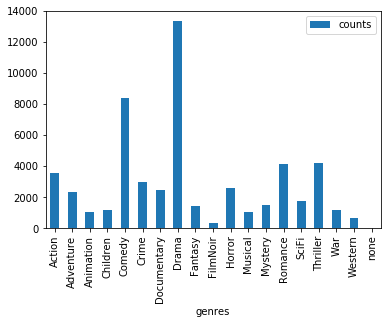

In [18]:
genres_pd = pd.DataFrame({'genres':genres_cat+['none'], 'counts':genres_cat_cnt})
genres_pd.set_index('genres').plot(kind = 'bar')

The genre column contains multiple labels which seem to characterize the movies. The predominant
category is “Drama” which characterizes approximately 50% of the movies names, followed by the
“Comedy” category that characterizes approximately 25% of the movies.

In [19]:
def function(x):
    try: 
        y = int(str(x).replace(')','').replace('(','').replace('-',''))
        return y
    except:
        return 0

movies_orig['year'] = movies_orig.title.str[-6:].apply(lambda x: function(x))


In [20]:
year_cat = list(movies_orig['year'].unique())
year_cnt = [0] * (len(year_cat)+1)

for movie_y in  movies_orig.year.tolist():
    for e,ycat in enumerate(year_cat):
        if ycat== movie_y:
#             print(ycat, e)
            year_cnt[e] +=1

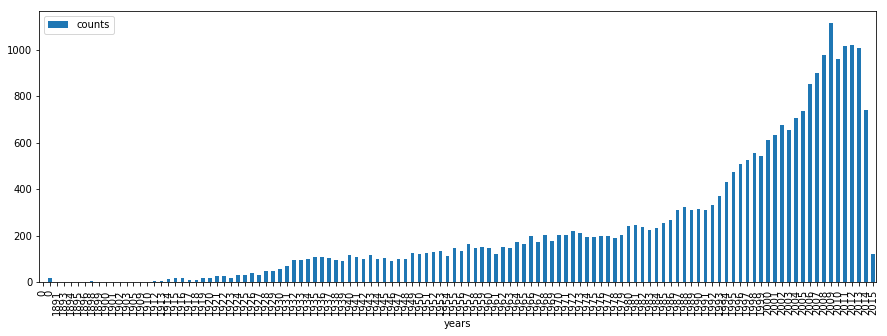

In [21]:
years_pd = pd.DataFrame({'years':year_cat+['none'], 'counts':year_cnt}).replace('none',0)
years_pd['years'] = years_pd['years'].astype(int)
years_pd = years_pd.sort_values(by='years')

years_pd.set_index('years').plot(kind = 'bar',figsize=(15,5))

Once the years have been extracted from the title vector, we can see that a large majority of the movies
are from the 90s and the 2000’s with a peak in 2009 and some missing values. Since the data counts
drops significantly after 2013 and data stops in 2015, our “relatedness” may be affected by the “side
effect” if we were using the year as a feature.

In [22]:
# load ratings file
ratings_orig = pd.read_csv('/jet/prs/workspace/Movie/ml20m/ratings.csv')
len(ratings_orig.movieId.unique()), ratings_orig.columns

(26744, Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [23]:
# my kaggle code for fast groupby
GROUPBY_AGGREGATIONS = [


    ######################################################################
    {'groupby': ['movieId'], 'select': 'rating', 'agg': 'mean'},
    {'groupby': ['movieId'], 'select': 'rating', 'agg': 'count'},
    {'groupby': ['movieId'], 'select': 'userId', 'agg': 'nunique'},
]

# Apply all the groupby transformations
for spec in GROUPBY_AGGREGATIONS:

    # Name of the aggregation we're applying
    agg_name = spec['agg_name'] if 'agg_name' in spec else spec['agg']

    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), agg_name, spec['select'])

    # Info
    print("Grouping by {}, and aggregating {} with {}".format(spec['groupby'], spec['select'], agg_name))

    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))

    # Perform the groupby
    gp = ratings_orig[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature})

    # Merge back to X_total
    movies_orig = movies_orig.merge(gp, on=spec['groupby'], how='left')

     # Clear memory
    del gp
    gc.collect()

movies_orig.head()

Grouping by ['movieId'], and aggregating rating with mean
Grouping by ['movieId'], and aggregating rating with count
Grouping by ['movieId'], and aggregating userId with nunique


,movieId,title,genres,year,movieId_mean_rating,movieId_count_rating,movieId_nunique_userId
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,3.921240,49695.0,49695.0
1,2,Jumanji (1995),Adventure Children Fantasy,1995,3.211977,22243.0,22243.0
2,3,Grumpier Old Men (1995),Comedy Romance,1995,3.151040,12735.0,12735.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,1995,2.861393,2756.0,2756.0
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592,12161.0,12161.0


In [24]:
movies_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27262 entries, 0 to 27261
Data columns (total 7 columns):
movieId                   27262 non-null int64
title                     27262 non-null object
genres                    27262 non-null object
year                      27262 non-null int64
movieId_mean_rating       26729 non-null float64
movieId_count_rating      26729 non-null float64
movieId_nunique_userId    26729 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.7+ MB


In [25]:
# base stats on user count
movies_orig.movieId_count_rating.median(), movies_orig.movieId_count_rating.mean(), movies_orig.movieId_count_rating.std()

(18.0, 746.05039470238319, 3075.8908289860851)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4c008ac18>]], dtype=object)

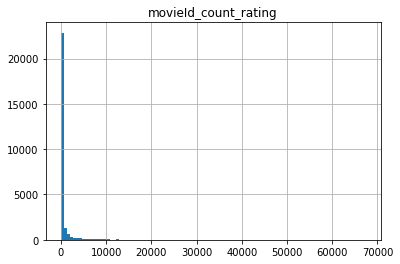

In [26]:
movies_orig.hist(column='movieId_count_rating',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bfe1f198>]], dtype=object)

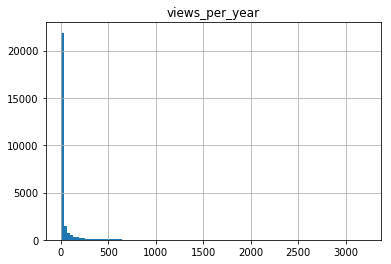

In [27]:
movies_orig['time_since_issuance']=movies_orig['year'].apply(lambda x: x if x >= 1995 else 1995) #to take account movies issued before 1995
movies_orig['views_per_year']=movies_orig['movieId_count_rating']/(2016-movies_orig['time_since_issuance'])
movies_orig['views_per_year'] = movies_orig['views_per_year'].apply(lambda x: x if pd.isnull(x) else int(x))
movies_orig.hist(column='views_per_year',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bfdec710>]], dtype=object)

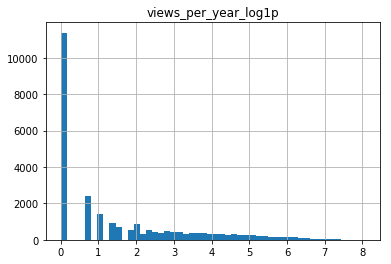

In [28]:
# try log1p to have a better understanding of the distribution
movies_orig['views_per_year_log1p']=movies_orig['views_per_year'].apply(lambda x: np.log1p(x))
movies_orig.hist(column='views_per_year_log1p',bins=50)

Since the movies were rated between 1995 and 2015, we will average the ratings count over the year in
order to rescale the figure on the same basis and since the scale of the count is still large, we will take
the log(x+1) in order to make the range more manageable.



In [29]:
movies_orig['views_per_year_log1p'].min(), movies_orig['views_per_year_log1p'].max()

(0.0, 8.0727793331694979)

In [30]:
# base stats on user count
movies_orig.movieId_mean_rating.median(), movies_orig.movieId_mean_rating.mean(), movies_orig.movieId_mean_rating.std()

(3.2352941176470589, 3.13320127627542, 0.66410091044600039)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bfb71fd0>]], dtype=object)

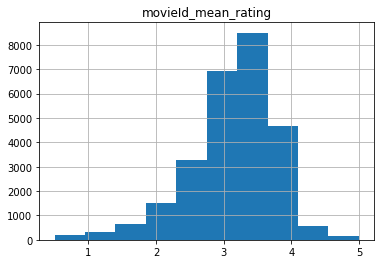

In [31]:
movies_orig.hist(column='movieId_mean_rating')

The ratings have a Gaussian distribution centered on the rating of 3. Given a std of 0.66, 95% of the
ratings are comprised between 2 and 4.5.

In [32]:
movies_orig[movies_orig.movieId_count_rating>10].shape

(15068, 10)

In [33]:
# movies_orig[movies_orig.movieId_count_rating!=movies_orig.movieId_nunique_userId]

In [34]:
### Note: the dataset needs some clean up
movies_orig[movies_orig.title.str.contains('ylon 5')]
### >> this is a TV show...

,movieId,title,genres,year,movieId_mean_rating,movieId_count_rating,movieId_nunique_userId,time_since_issuance,views_per_year,views_per_year_log1p
7409,7649,Babylon 5: In the Beginning (1998),Adventure SciFi,1998,3.675935,1043.0,1043.0,1998,57.0,4.060443
7484,7810,Babylon 5: A Call to Arms (1999),Adventure SciFi,1999,3.551601,562.0,562.0,1999,33.0,3.526361
7485,7811,Babylon 5: The River of Souls (1998),Drama SciFi,1998,3.273810,420.0,420.0,1998,23.0,3.178054
7486,7812,Babylon 5: Thirdspace (1998),Drama SciFi,1998,3.364773,440.0,440.0,1998,24.0,3.218876
10588,40697,Babylon 5,SciFi,0,3.866071,56.0,56.0,1995,2.0,1.098612
11687,51562,Babylon 5: The Gathering (1993),SciFi,1993,3.487500,160.0,160.0,1995,7.0,2.079442
13073,62834,Babylon 5: The Legend of the Rangers: To Live ...,SciFi,2002,2.952991,117.0,117.0,2002,8.0,2.197225
13074,62836,Babylon 5: The Lost Tales - Voices in the Dark...,SciFi,2007,3.218447,103.0,103.0,2007,11.0,2.484907


# 1. Simple relatedness method based on description and genre

A simple idea in order to answer the challenge is to use the description and the genres vectors and find
similarities in the text of the description and in the genres categories in order to rank the relation
between movies. This method is closer to an unsupervised method (or clustering method) and is called
content based filtering method in the field of the recommendation engines.

For purpose of simplicity, in this prototype, the description and genres vectors are merged together.
In order to find the similarities in the movies’ description and genres vectors containing some text, we
used the TFIDF implementation in scikit-learn. The method counts the different words in the text
attributes of each observation and substitutes the text vector with a word count vector. The method
advantage is that these matrices are sparse (lot of 0s), are scalable but it only concentrated on word
frequency, and it ignore the meaning between words or word declination (conjugations). A cosine
similarity matrix is then calculated based on this tfidf matrix and calculates a number between 0
(different) and 1 (identical) which is similar to a distance (in a distance, two items can be identical with a
0 distance and infinite if they are really different).


In [35]:
## load the file created with the scraping website
links_desc = pd.read_csv('/jet/prs/workspace/Movie/ml20m/movie_desc.csv')

In [36]:
movies_desc = movies_orig.merge(links_desc, on='movieId', how='left')

In [37]:
movies_desc['genres_desc']=movies_desc['genres']+ " "+ movies_desc['desc']

In [38]:
# movies_desc = movies_desc[movies_desc.genres_desc.notnull()]
movies_desc = movies_desc[movies_desc.desc.notnull()]
movies_desc.shape

(4993, 15)

In [39]:
movies_desc.head()

,movieId,title,genres,year,movieId_mean_rating,movieId_count_rating,movieId_nunique_userId,time_since_issuance,views_per_year,views_per_year_log1p,Unnamed: 0,imdbId,tmdbId,desc,genres_desc
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,3.921240,49695.0,49695.0,1995,2366.0,7.769379,0.0,114709.0,862.0,"Led by Woody, Andy's toys live happily in his ...",Adventure Animation Children Comedy Fantasy Le...
1,2,Jumanji (1995),Adventure Children Fantasy,1995,3.211977,22243.0,22243.0,1995,1059.0,6.966024,1.0,113497.0,8844.0,When siblings Judy and Peter discover an encha...,Adventure Children Fantasy When siblings Judy ...
2,3,Grumpier Old Men (1995),Comedy Romance,1995,3.151040,12735.0,12735.0,1995,606.0,6.408529,2.0,113228.0,15602.0,A family wedding reignites the ancient feud be...,Comedy Romance A family wedding reignites the ...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,1995,2.861393,2756.0,2756.0,1995,131.0,4.882802,3.0,114885.0,31357.0,"Cheated on, mistreated and stepped on, the wom...","Comedy Drama Romance Cheated on, mistreated an..."
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592,12161.0,12161.0,1995,579.0,6.363028,4.0,113041.0,11862.0,Just when George Banks has recovered from his ...,Comedy Just when George Banks has recovered fr...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# define tfidf parameter in order to count/vectorize the description vector and then normalize it.
model_tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 5), min_df=1, stop_words='english')
tfidf_matrice = model_tf.fit_transform(movies_desc['genres_desc'])

NameError: name 'movies_desc' is not defined

In [41]:
tfidf_matrice.shape

(4993, 559547)

In [2]:
# since the matrix is normalized, we can do the dot product using:
cosine_similarite = linear_kernel(tfidf_matrice, tfidf_matrice)

NameError: name 'tfidf_matrice' is not defined

In [43]:
cosine_similarite[0]

array([  1.00000000e+00,   5.69663728e-03,   3.53709138e-04, ...,
         9.37116215e-04,   3.42407397e-04,   1.17169606e-03])

In [44]:
# fonction to output the list of ordered movies with the most similarities

movies_desc = movies_desc.reset_index(drop=True)
movies_ID = movies_desc['movieId']
movies_title = movies_desc['title']
indices = pd.Series(movies_desc.index, index=movies_desc['movieId'])

def some_recommendations(movie_id, rec_nb=100):
    idx = indices[movie_id]
    #sort by order of similarity from 1 to 0:
    similarity_scores = list(enumerate(cosine_similarite[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:rec_nb]
    movie_indices = [i[0] for i in similarity_scores]
    return print('Movie input:', movies_title.iloc[idx]), print('\n \nOrdered related movies: \n',movies_title.iloc[movie_indices])

In [45]:
some_recommendations(1,15)

Movie input: Toy Story (1995)

 
Ordered related movies: 
 2989                                 Toy Story 2 (1999)
4747                              Monsters, Inc. (2001)
661                                    Space Jam (1996)
4169                                       Shrek (2001)
2174                                        Antz (1998)
3623     Adventures of Rocky and Bullwinkle, The (2000)
1876                              Child's Play 2 (1990)
3882                   Emperor's New Groove, The (2000)
1068                       Rebel Without a Cause (1955)
1925                                   Condorman (1981)
2235                               Bug's Life, A (1998)
1176    Grand Day Out with Wallace and Gromit, A (1989)
4851                   Jimmy Neutron: Boy Genius (2001)
3049                             Man on the Moon (1999)
Name: title, dtype: object


(None, None)

In [46]:
some_recommendations(858,15)

Movie input: Godfather, The (1972)

 
Ordered related movies: 
 1174                       Godfather: Part II, The (1974)
29      Shanghai Triad (Yao a yao yao dao waipo qiao) ...
1907                      Godfather: Part III, The (1990)
4315                                          Made (2001)
2883                                American Movie (1999)
4464                                 Harlem Nights (1989)
3286                                        Impact (1949)
2616                             Color Purple, The (1985)
3887                            Before Night Falls (2000)
2579                                 Summer of Sam (1999)
4296                           Written on the Wind (1956)
3989                             Jaws: The Revenge (1987)
4609                                      3 Ninjas (1992)
1867                                  Halloween II (1981)
Name: title, dtype: object


(None, None)

These are our first ouput which are quite satisfying. As shown by the results, the year range is quite large.

An alternative to the tdidf transformation would have been to use the Word2Vec as it is able to find
word declination and similar expression in a sentence. However, Word2Vec produces a dense matrix
which is not as easily scalable.

# 2. Relatedness method based on weighted features 

As mentioned before, we can increase the number of features in order to find more similarities between
movies: the titles are likely to show that two movies are related if they contains the same word, close
average ratings of two different movies may reveal movies of the same quality, comparing the year of
issuance of two movies shall help finding movies of the same period.

Cosine matrices are calculated for the description, titles and genres respectively. Since the ratings, views
(number of ratings received) and year of issuance are on interval scale, we can the absolute value of the
difference for the distance (it needs to be rescaled between 0 and 1 and reshaped into 1-distance to be
homogenous to the cosine similarity).

In [47]:
# extract the title and year from the title column into 2 features
movies_met2 = movies_desc.copy()
movies_met2['title_simple'] = movies_met2.title.str[:-6]

movies_met2.head()

,movieId,title,genres,year,movieId_mean_rating,movieId_count_rating,movieId_nunique_userId,time_since_issuance,views_per_year,views_per_year_log1p,Unnamed: 0,imdbId,tmdbId,desc,genres_desc,title_simple
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,3.921240,49695.0,49695.0,1995,2366.0,7.769379,0.0,114709.0,862.0,"Led by Woody, Andy's toys live happily in his ...",Adventure Animation Children Comedy Fantasy Le...,Toy Story
1,2,Jumanji (1995),Adventure Children Fantasy,1995,3.211977,22243.0,22243.0,1995,1059.0,6.966024,1.0,113497.0,8844.0,When siblings Judy and Peter discover an encha...,Adventure Children Fantasy When siblings Judy ...,Jumanji
2,3,Grumpier Old Men (1995),Comedy Romance,1995,3.151040,12735.0,12735.0,1995,606.0,6.408529,2.0,113228.0,15602.0,A family wedding reignites the ancient feud be...,Comedy Romance A family wedding reignites the ...,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy Drama Romance,1995,2.861393,2756.0,2756.0,1995,131.0,4.882802,3.0,114885.0,31357.0,"Cheated on, mistreated and stepped on, the wom...","Comedy Drama Romance Cheated on, mistreated an...",Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592,12161.0,12161.0,1995,579.0,6.363028,4.0,113041.0,11862.0,Just when George Banks has recovered from his ...,Comedy Just when George Banks has recovered fr...,Father of the Bride Part II


In [48]:
overall_avg_rating = movies_met2.movieId_mean_rating.mean() 
print('overall_avg_rating: ',overall_avg_rating)

overall_avg_user_cnt = movies_met2.views_per_year_log1p.mean() 
print('overall_avg_user_cnt: ',overall_avg_user_cnt)

overall_avg_rating:  3.18137883841
overall_avg_user_cnt:  3.64359667533


In [49]:
model_tf_desc = TfidfVectorizer(analyzer='word',ngram_range=(1, 5), min_df=1, stop_words='english')
tfidf_matrice_desc = model_tf_desc.fit_transform(movies_met2['desc'])
cosine_similarite_desc = linear_kernel(tfidf_matrice_desc, tfidf_matrice_desc)

model_tf_genre = TfidfVectorizer(analyzer='word',ngram_range=(1, 10), min_df=1, stop_words='english')
tfidf_matrice_genre = model_tf_genre.fit_transform(movies_met2['genres'])
cosine_similarite_genre = linear_kernel(tfidf_matrice_genre, tfidf_matrice_genre)

model_tf_title = TfidfVectorizer(analyzer='word',ngram_range=(1, 3), min_df=1, stop_words='english')
tfidf_matrice_title = model_tf_genre.fit_transform(movies_met2['title_simple'])
cosine_similarite_title = linear_kernel(tfidf_matrice_title, tfidf_matrice_title)

tfidf_matrice_desc.shape, tfidf_matrice_genre.shape, tfidf_matrice_title.shape

((4993, 528329), (4993, 774), (4993, 16791))

In [50]:
cosine_similarite_desc[0].shape

(4993,)

In [51]:
# transform the user count into log1p in order to rescale the  
movies_title = movies_met2['title']

In [52]:
# modified function to output the list of ordered movies

movies_met2 = movies_met2.reset_index(drop=True)
movies_ID = movies_met2['movieId']
movies_title = movies_met2['title']
indices = pd.Series(movies_met2.index, index=movies_met2['movieId'])


# Parameter weights on 6 differents features
# decriptionSimilarityWeight = 1
# genresSimilarityWeight = .8
# titleSimilarityWeight = .8
# viewsSimilarityWeight = .5
# ratingAvgWeight = .5
# yearDistanceWeight = .2


decriptionSimilarityWeight = 1
genresSimilarityWeight = 1
titleSimilarityWeight = .8
viewsSimilarityWeight = .1
ratingAvgWeight = 1
yearDistanceWeight = .2


def some_recommendations_met2(movie_id, rec_nb=100):
    idx = indices[movie_id]
    
    desc_sim = cosine_similarite_desc[idx]*decriptionSimilarityWeight
    genre_sim = cosine_similarite_genre[idx]*genresSimilarityWeight
    title_sim = cosine_similarite_title[idx]*titleSimilarityWeight
    
    movie_id_rating = movies_met2[movies_met2['movieId'] == movie_id]['movieId_mean_rating'].values
    rating_sim = (1-abs(np.array(movies_met2['movieId_mean_rating'])-movie_id_rating)/5)*ratingAvgWeight
#     print(rating_sim.max())
    
    movie_id_views = movies_met2[movies_met2['movieId'] == movie_id]['views_per_year_log1p'].values
    views_sim = (1-abs(np.array(movies_met2['views_per_year_log1p'])-movie_id_views)/11)*viewsSimilarityWeight
#     print(views_sim.max())
    
    movie_id_year = movies_met2[movies_met2['movieId'] == movie_id]['year'].values
    year_sim = (1-abs(np.array(movies_met2['year'])-movie_id_year)/20)*yearDistanceWeight
#     print(year_sim.max())
    
    similarite_total = desc_sim+genre_sim+title_sim+rating_sim+views_sim+year_sim
 
    
    similarity_scores = list(enumerate(similarite_total))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:rec_nb]
    movie_indices = [i[0] for i in similarity_scores]
    return print('movie input:', movies_title.iloc[idx]), print('\n',movies_title.iloc[movie_indices])

In [53]:
# movies_met2[movies_met2.title.str.contains('father')]

In [56]:
some_recommendations_met2(1,15) #858 2023

movie input: Toy Story (1995)

 2989                                 Toy Story 2 (1999)
4747                              Monsters, Inc. (2001)
3882                   Emperor's New Groove, The (2000)
2174                                        Antz (1998)
4169                                       Shrek (2001)
2235                               Bug's Life, A (1998)
3623     Adventures of Rocky and Bullwinkle, The (2000)
2025                           American Tail, An (1986)
661                                    Space Jam (1996)
725              Wallace & Gromit: A Close Shave (1995)
4851                   Jimmy Neutron: Boy Genius (2001)
1176    Grand Day Out with Wallace and Gromit, A (1989)
3620                                 Chicken Run (2000)
811                                      Matilda (1996)
Name: title, dtype: object


(None, None)

In [57]:
some_recommendations_met2(858,15) #858 2023

movie input: Godfather, The (1972)

 1174                       Godfather: Part II, The (1974)
3072                                      Papillon (1973)
3604                                       Serpico (1973)
3236                             Dog Day Afternoon (1975)
4917    Enigma of Kaspar Hauser, The (a.k.a. Mystery o...
1049                              Bonnie and Clyde (1967)
2608       400 Blows, The (Les quatre cents coups) (1959)
1166                                    Goodfellas (1990)
1180                   Once Upon a Time in America (1984)
1829                             On the Waterfront (1954)
314                      Shawshank Redemption, The (1994)
3178                                   Blue Collar (1978)
3458                   King of Marvin Gardens, The (1972)
4557                          Who'll Stop the Rain (1978)
Name: title, dtype: object


(None, None)

In this second attempt, the movies are much closer in term of time period.

Unfortunately, given the unsupervised method, these two methods have the inconvenient to take only
the view of the author of the code.

Instead of assessing the results visually, we could have used a metric such as recall traditionally used in
recommendation engine. Recall@n corresponds to the rate of # movies recommended and relevant in
the top n divided by n, number of movies recommended. The relevance of a movie has to be defined
and traditionally, movies are relevant to the user if the movie ratings are rated higher than a fixed
threshold. Then we can imagine looking for the optimal values of the feature weight parameters in order
to optimize the recall function using the entire data.

# 3. SVD method (Matrix factorization): 

One way to individualize the “relatedness” of movies for a particular user is to know his preferences.
The users’ preferences are usually collected through the ratings that the user has seen: matrix
decomposition is a way to predict the rating for a movie not already rated by a user.
The matrix decomposition (SVD) is, to simplify, a ranked and reduced approximation of a dataset
structure that would generalize to new data.

Instead of a unique input (MovieId), taken into account the individuality of the recommendation will
require two inputs: MovieId and UserId and output an estimated rating.
    


In [58]:
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import GridSearchCV

In [59]:
# load ratings file
ratings_orig = pd.read_csv('/jet/prs/workspace/Movie/ml20m/ratings.csv')
ratings_orig['movieId'] = ratings_orig['movieId'].astype(int)
len(ratings_orig.movieId.unique()), ratings_orig.columns

(26744, Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [60]:
ratings_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [61]:
ratings_orig.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [62]:
ratings_orig['movieId'].shape

(20000263,)

In [63]:
# for consistency, we only keep the moviesId selected above
ratings_orig = ratings_orig.loc[ratings_orig['movieId'].isin(movies_met2.movieId.tolist())]
ratings_orig.shape

(15399958, 4)

In [64]:
# https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset

reader = Reader()
data = Dataset.load_from_df(ratings_orig[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)

In [ ]:

# param_grid = {'n_epochs': [2, 5, 10, 15], 
#               'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6],
#              }
# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# gs.fit(data )

# # best RMSE score
# print(gs.best_score['rmse'])

# # combination of parameters that gave the best RMSE score
# print(gs.best_params['rmse'])

In [66]:
# Results
# 0.893147497881
# {'n_epochs': 15, 'lr_all': 0.002, 'reg_all': 0.4}

In [67]:
#given the parameters from the Gridsearch:
svd = SVD(n_epochs=15, lr_all=0.002, reg_all=0.4)

In [68]:
# we retrained on full dataset:
full_trn = data.build_full_trainset()
svd.fit(full_trn)

In [69]:
ratings_orig[ratings_orig['userId'] == 1].head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [75]:
# this user#1 has been using the spectrum of ratings
ratings_orig[ratings_orig['userId'] == 1]['rating'].mean(), ratings_orig[ratings_orig['userId'] == 1]['rating'].std()

(3.7185185185185183, 0.3541197169153909)

In [71]:
svd.predict(1, 1)

Prediction(uid=1, iid=1, r_ui=None, est=3.8494515896441737, details={'was_impossible': False})

In [73]:
print('estimated rating of user #1 for movie id #1 is : ', svd.predict(1, 1).est)

estimated rating of user #1 for movie id #1 is :  3.84945158964


In [74]:
ratings_orig[(ratings_orig['userId'] == 1) & (ratings_orig['movieId'] >= 850)].head()

,userId,movieId,rating,timestamp
19,1,919,3.5,1094785621
20,1,924,3.5,1094785598
21,1,1009,3.5,1112486013
22,1,1036,4.0,1112485480
23,1,1079,4.0,1094785665


In [76]:
print('estimated rating of user #1 for movie id #858 is : ', svd.predict(1, 858).est)

estimated rating of user #1 for movie id #858 is :  4.1107564988


The estimated ratings can be used by itself or with the movie’s features we suggested in the previous
part to make individualized movie recommendations.

One thing to dig in SVD is the meaning/repurpose of U and V in M = U.D.V* 

# 4. other potential methods to explore: 

A. Sequence or one-to-Sequence (time series)

Since the movies have an issuance date and a time is provided for the users’ ratings, we could transform
the history of movies seen by an user into a time series problem where a movie and its characteristics
(which can be associated to a user and its characteristics) are the inputs and the model predict a list of
movies as an output. The advantage of this method is that it can take a lot of features as inputs.
However, using deep learning neural network (LSTM), it would require a lot of ordered observations.

B. Learning to rank

In the time allocated to this challenge, I also read about Learning to rank (and pairwise ranking).
Understanding how to implement such models would require additional research.